In [1]:
# Get the Olivetti Faces dataset
from sklearn.datasets import fetch_olivetti_faces

RANDOM_STATE = 42
faces_data = fetch_olivetti_faces(data_home="data",
                                  shuffle=True,
                                  random_state=RANDOM_STATE,
                                  download_if_missing=True)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to data


In [2]:
# Check the shapes of your data
X = faces_data.images  # the images
y = faces_data.target # the lavels or targets

print(f"Length of X: {len(X)} and y: {len(y)}")
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Length of X: 400 and y: 400
Shape of X: (400, 64, 64)
Shape of y: (400,)


In [3]:
# Reshape the data for CNN -> [color_channels, height, width]
X = X.reshape(-1, 1, 64, 64)

print(f"Shape of X after reshape: {X.shape}")

Shape of X after reshape: (400, 1, 64, 64)


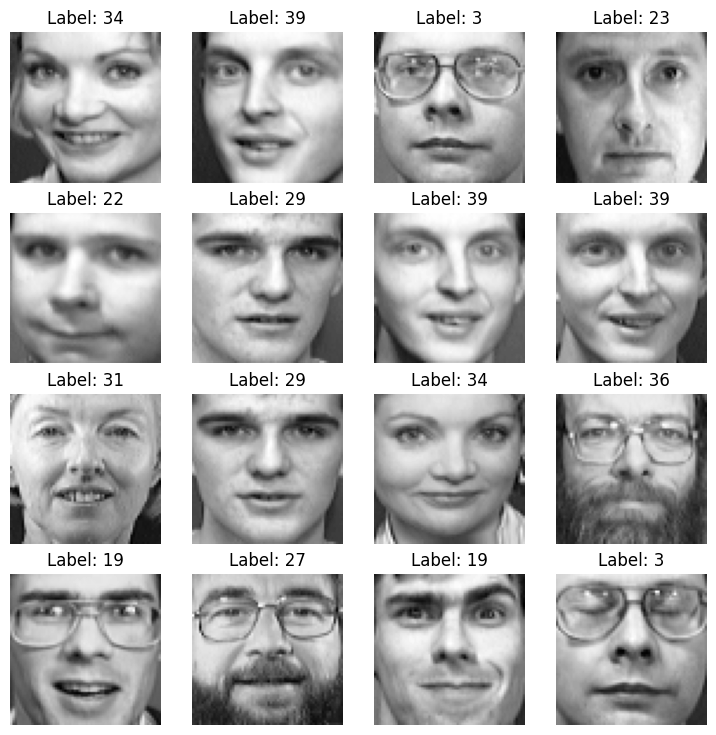

In [4]:
# Plot random samples from the data
import matplotlib.pyplot as plt
import random

fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols + 1):
  random_idx = random.randint(0, len(y))
  image, label = X[random_idx], y[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(image.squeeze(), cmap="gray")
  plt.title(f"Label: {label}")
  plt.axis(False);

In [5]:
# Splitting the dataset into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% for testing, 80% for training
                                                    random_state=RANDOM_STATE)

print(len(X_train), len(y_train), len(X_test), len(y_test))

# Convert NumPy arrays to PyTorch tensors
import torch

X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

320 320 80 80


In [6]:
# Create DataLoader for handling batches during training and testing
from torch.utils.data import DataLoader, TensorDataset
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

BATCH_SIZE = 20
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fec5e533be0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fec5e533ca0>)

In [7]:
# Make a device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Currect device: {device}")

Currect device: cuda


In [8]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([20, 1, 64, 64]), torch.Size([20]))

Image size: torch.Size([1, 64, 64])
Label: 34, label size: torch.Size([])


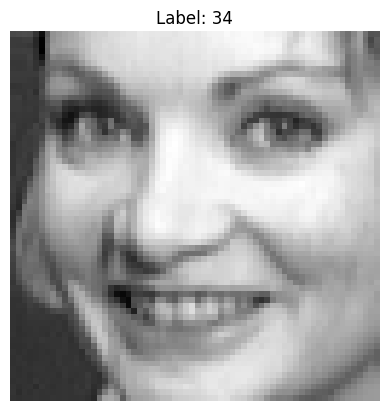

In [9]:
# Show a sample
import random
random_idx = random.randint(0, len(train_features_batch))
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(f"Label: {label}")
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

In [10]:
# Build a CNN model
from torch import nn
class CNNModel(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
    x = self.block_1(x)
    # print(x.shape)
    x = self.block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x

# Instantiate the model, define loss function and optimizer
torch.manual_seed(42)
model = CNNModel(
    input_shape=1,
    hidden_units=10,
    output_shape=40 # or len(np.unique(y))
    ).to(device)

loss_fn = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # optimizer

In [11]:
# Check if the model works without errors
# 1. Get a batch of images and labels
image_batch, label_batch = train_features_batch[0], train_labels_batch[0]
print(f"Single image size: {image_batch.shape}\n\t\t[color_channels, height, width]")

# 2 . Perform a forward pass on a single image
model.eval()
with torch.inference_mode():
  pred = model(image_batch.unsqueeze(dim=0).to(device))
  # pred = model(train_features_batch)

# 4 Print out
print(f"Length output logits: {len(pred)}\n")
print(f"Output logits:\n{pred.shape}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_batch}")

Single image size: torch.Size([1, 64, 64])
		[color_channels, height, width]
Length output logits: 1

Output logits:
torch.Size([1, 40])

Output prediction probabilities:
tensor([[0.0253, 0.0242, 0.0243, 0.0251, 0.0247, 0.0247, 0.0243, 0.0259, 0.0257,
         0.0248, 0.0250, 0.0245, 0.0248, 0.0253, 0.0254, 0.0254, 0.0242, 0.0255,
         0.0244, 0.0244, 0.0244, 0.0254, 0.0253, 0.0251, 0.0250, 0.0251, 0.0249,
         0.0238, 0.0250, 0.0257, 0.0247, 0.0266, 0.0247, 0.0249, 0.0250, 0.0243,
         0.0260, 0.0251, 0.0255, 0.0259]], device='cuda:0')

Output prediction label:
tensor([31], device='cuda:0')

Actual label:
31


In [12]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

### Train
epochs = 40
for epoch in tqdm(range(epochs)):
  model.train()
  train_loss = 0
  train_acc = 0
  # Add a loop to loop through training batches
  for i, data in enumerate(train_dataloader, 0):
    images, labels = data
    # Send the data into targetdevice
    images, labels = images.to(device), labels.to(device)
    # 1. Forward pass
    output_images = model(images)
    # 2. Calculate the loss
    loss = loss_fn(output_images, labels)
    train_loss += loss.item()
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    # 4. Loss backward
    loss.backward()
    # 5. Optimizer step
    optimizer.step()
    # Calculate and accumulate accuracy metric across all batches
    y_pred_labels = torch.argmax(torch.softmax(output_images, dim=1), dim=1)
    train_acc += (y_pred_labels == labels).sum().item()/len(output_images)
  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(train_dataloader)
  train_acc = train_acc / len(train_dataloader)

  ### Evaluation on the test set
  model.eval()
  test_loss = 0
  test_acc = 0
  # Turn on inference context manager
  with torch.inference_mode():
    for data in test_dataloader:
      images_test, labels_test = data
      # Send data to target device
      images_test, labels_test = images_test.to(device), labels_test.to(device)
      # 1. Forward pass
      test_pred_label_logits = model(images_test)
      # 2. Calculatea and accumulate loss
      loss = loss_fn(test_pred_label_logits, labels_test)
      test_loss += loss.item()
      # Calculate and accumulate accuracy
      test_pred_labels = test_pred_label_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == labels_test).sum().item()/len(test_pred_labels))
  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(test_dataloader)
  test_acc = test_acc / len(test_dataloader)
  if (epoch) % 4 == 0:
    print(f"\n------------------------- Epoch: {epoch} -------------------------")
    print(f"Train loss: {train_loss} | Train accuracy: {train_acc * 100:.2f}%")
    print(f"Test loss: {test_loss} | Test accuracy: {test_acc * 100:.2f}%")

  0%|          | 0/40 [00:00<?, ?it/s]


------------------------- Epoch: 0 -------------------------
Train loss: 3.7306664139032364 | Train accuracy: 2.19%
Test loss: 3.7283767461776733 | Test accuracy: 1.25%

------------------------- Epoch: 4 -------------------------
Train loss: 2.4409036189317703 | Train accuracy: 42.81%
Test loss: 1.8219192326068878 | Test accuracy: 57.50%

------------------------- Epoch: 8 -------------------------
Train loss: 0.11776056996313855 | Train accuracy: 96.56%
Test loss: 0.650089792907238 | Test accuracy: 78.75%

------------------------- Epoch: 12 -------------------------
Train loss: 0.019030264316825196 | Train accuracy: 99.38%
Test loss: 0.30678615160286427 | Test accuracy: 92.50%

------------------------- Epoch: 16 -------------------------
Train loss: 0.0014593429768865462 | Train accuracy: 100.00%
Test loss: 0.22830577939748764 | Test accuracy: 95.00%

------------------------- Epoch: 20 -------------------------
Train loss: 0.0009696944907773286 | Train accuracy: 100.00%
Test loss

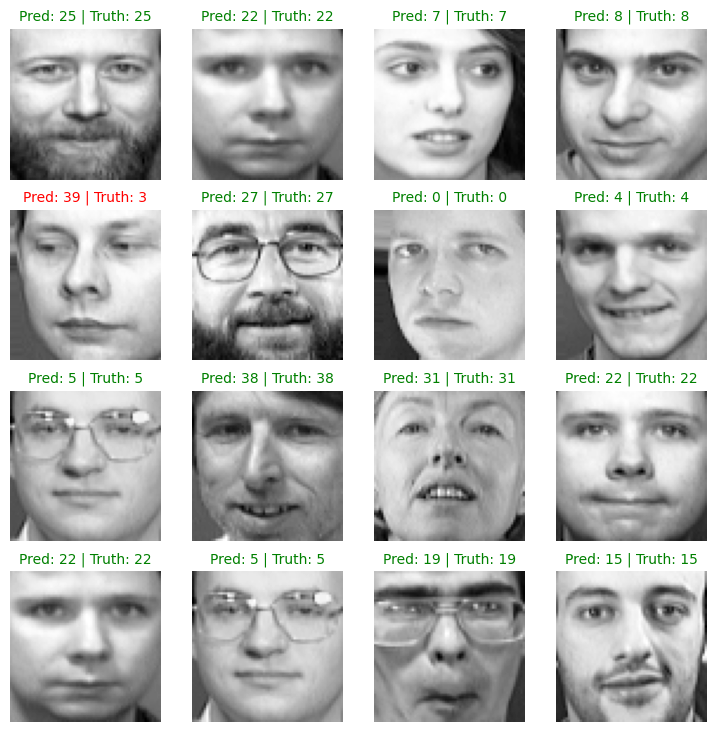

In [13]:
import random
random.seed(42)
import matplotlib.pyplot as plt
num_to_plot = 5
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols + 1 ):
  # Get image and labels from the test data
  random_idx = random.randint(0, len(y_test)-1)
  img = X_test[random_idx]
  truth_label = y_test[random_idx]

  # Make prediction on image
  model_pred_logits = model(img.unsqueeze(dim=0).to(device))
  model_pred_probs = torch.softmax(model_pred_logits, dim=1)
  model_pred_label = torch.argmax(model_pred_probs, dim=1)

  # Plot the image and prediction
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  title_text = f"Pred: {model_pred_label.item()} | Truth: {truth_label}"
  if model_pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")
  plt.axis(False);

In [14]:
len(y)

400

In [15]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
model.eval()
y_preds = []
# Turn on inference context manager
with torch.inference_mode():
  for data in tqdm(test_dataloader, desc="Making predictions"):
    images_test, labels_test = data
    # Send data to target device
    images_test, labels_test = images_test.to(device), labels_test.to(device)
    # 1. Forward pass
    test_pred_label_logits = model(images_test)
    # 2. Calculatea and accumulate loss
    loss = loss_fn(test_pred_label_logits, labels_test)
    test_loss += loss.item()
    # Calculate and accumulate accuracy
    test_pred_labels = test_pred_label_logits.argmax(dim=1)
    y_preds.append(test_pred_labels.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/4 [00:00<?, ?it/s]

In [16]:
y_pred_tensor

tensor([18,  0,  5, 22, 22, 27, 16, 18, 31, 35, 12,  5, 22,  0, 25,  7, 25, 27,
         9, 35, 36,  4, 12, 24, 20, 10, 29, 19, 39, 15,  7,  8,  1, 17, 23,  7,
        38, 26, 31, 13, 30,  3, 22, 39, 20, 14, 16, 14, 39,  9, 14, 29,  5, 32,
        31, 14, 13, 12, 39, 27,  2, 20, 36, 17, 11, 19, 27, 22, 18,  4, 21, 22,
         8, 38,  8, 38, 39,  4,  9, 21])

In [17]:
y_test

tensor([18,  0,  5, 22, 22, 27, 16, 18, 31, 35, 12,  5, 22,  0, 25,  7, 25, 27,
        23, 35, 36,  4, 12, 24, 20, 10, 29, 19,  3, 15,  7,  8,  1, 17, 23,  7,
        38, 26, 31, 13, 30,  3, 22, 39, 20, 14, 16, 14, 39,  9, 14, 29,  4, 32,
        31, 14, 13, 12, 39, 27,  2, 20, 36, 17, 11, 19, 27, 22, 18,  4, 21,  3,
         8, 38,  8, 38, 39,  4,  9, 21])

In [18]:
y_test == y_pred_tensor

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True])